# Лабораторна робота No6. Виявлення об’єктiв (object detection) на вiдео та зображеннях

1. Підготувати середовище

In [1]:
import random
import numpy as np
import tensorflow as tf
import keras_cv

from src.data.uav_object_detection import create_uav_object_detection_ds
from src.visualization.image import sample_obj_detection_dataset, visualize_detections
from src.visualization.plot import plot_loss_and_val_accuracy, plot_loss_and_val_loss
from src.definitions import MODELS_FOLDER

from lib.metrics.coco_metrics import EvaluateCOCOMetricsCallback

random_seed = 42

tf.random.set_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

Using TensorFlow backend


2. Обрати будь-який датасет

In [2]:
train_ds, test_ds = create_uav_object_detection_ds()

class_mapping = ["drone"]

print(f"Train dataset size: {len(train_ds)} batches")
print(f"Train dataset size: {len(test_ds)} batches")

Train dataset size: 11 batches
Train dataset size: 1 batches


2024-12-13 23:26:26.162605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:26:27.024947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:26:27.222895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


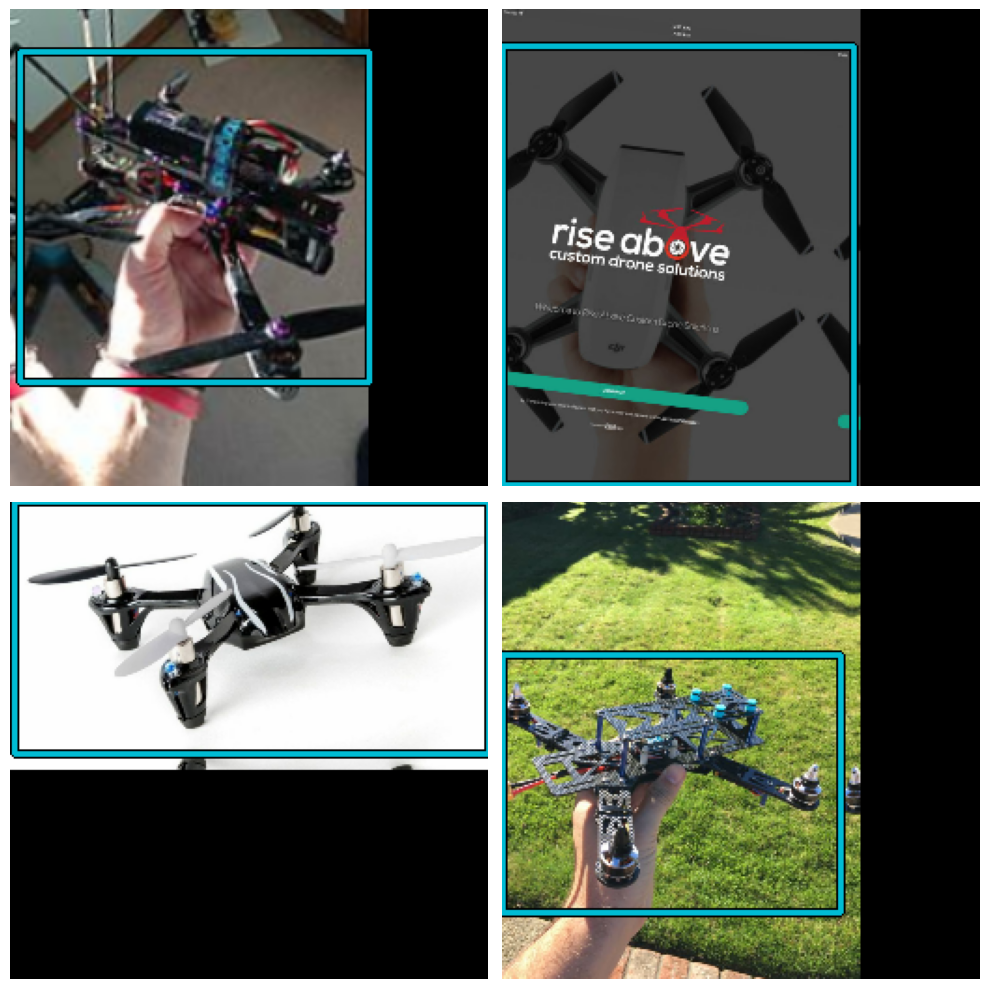

In [3]:
sample_obj_detection_dataset(
    train_ds,
    bounding_box_format="xyxy",
    value_range=(0, 255),
    rows=2,
    cols=2,
    class_mapping=class_mapping,
)

3. Реалiзувати базову модель власноруч (за бажанням) або встановити одну з моделей YOLO (v8, v9 або v10)

In [4]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco" 
)

yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=0.01,
    global_clipnorm=10,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

/Users/alexandermelashchenko/Workspace/computer-vision/.venv/lib/python3.11/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/alexandermelashchenko/Workspace/computer-vision/.venv/lib/python3.11/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


4. Попередньо обробити та пiдоготувати датасет для обраної моделi YOLO.

In [5]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

5. Навчити обрану модель на датасетi.

In [6]:
train_feedback = yolo.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=[EvaluateCOCOMetricsCallback(test_ds, MODELS_FOLDER / "detect-uav-yolo.h5")],
)

Epoch 1/10


2024-12-13 23:26:37.713419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:26:38.547405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:26:38.754953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 107.3406 - box_loss: 3.3157 - class_loss: 104.0249

2024-12-13 23:27:12.997582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:27:14.671322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 46s 3s/step - loss: 107.3406 - box_loss: 3.3157 - class_loss: 104.0249 - val_loss: 689.9697 - val_box_loss: 3.5670 - val_class_loss: 686.4027 - MaP: 0.0017 - MaP@[IoU=50]: 0.0059 - MaP@[IoU=75]: 4.6203e-05 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0239 - MaP@[area=large]: 0.0021 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.2147 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0882 - Recall@[area=large]: 0.3042


/Users/alexandermelashchenko/Workspace/computer-vision/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10


2024-12-13 23:27:18.862884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:27:19.704782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:27:19.917242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 17.0783 - box_loss: 2.5521 - class_loss: 14.5262

2024-12-13 23:27:51.877145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:27:53.523572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 37s 3s/step - loss: 17.0783 - box_loss: 2.5521 - class_loss: 14.5262 - val_loss: 0.0000e+00 - val_box_loss: 0.0000e+00 - val_class_loss: 0.0000e+00 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 3/10


2024-12-13 23:27:55.751540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:27:56.598199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:27:56.816126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 5.5796 - box_loss: 2.4514 - class_loss: 3.1281

2024-12-13 23:28:27.825754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:28:29.485901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 36s 3s/step - loss: 5.5796 - box_loss: 2.4514 - class_loss: 3.1281 - val_loss: 0.0000e+00 - val_box_loss: 0.0000e+00 - val_class_loss: 0.0000e+00 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 4/10


2024-12-13 23:28:31.690267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:28:32.515204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:28:32.721187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 5.1763 - box_loss: 2.5164 - class_loss: 2.6600

2024-12-13 23:29:03.838746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:29:05.513788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 36s 3s/step - loss: 5.1763 - box_loss: 2.5164 - class_loss: 2.6600 - val_loss: 0.0000e+00 - val_box_loss: 0.0000e+00 - val_class_loss: 0.0000e+00 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 5/10


2024-12-13 23:29:07.960407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:29:08.769261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:29:08.970891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 5.1466 - box_loss: 2.4835 - class_loss: 2.6631

2024-12-13 23:29:41.251570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:29:43.030877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 37s 3s/step - loss: 5.1466 - box_loss: 2.4835 - class_loss: 2.6631 - val_loss: 22.3729 - val_box_loss: 2.9305 - val_class_loss: 19.4424 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 6/10


2024-12-13 23:29:45.216349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:29:46.056209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:29:46.269322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 4.9253 - box_loss: 2.4748 - class_loss: 2.4505

2024-12-13 23:30:18.550160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:30:20.225880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 37s 3s/step - loss: 4.9253 - box_loss: 2.4748 - class_loss: 2.4505 - val_loss: 15.2796 - val_box_loss: 2.8979 - val_class_loss: 12.3817 - MaP: 0.0277 - MaP@[IoU=50]: 0.0589 - MaP@[IoU=75]: 0.0216 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0401 - Recall@[max_detections=1]: 0.2393 - Recall@[max_detections=10]: 0.2929 - Recall@[max_detections=100]: 0.2929 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.4316
Epoch 7/10


2024-12-13 23:30:22.647667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:30:23.482216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:30:23.682085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 4.8980 - box_loss: 2.4831 - class_loss: 2.4149

2024-12-13 23:30:56.360499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:30:57.986621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 37s 3s/step - loss: 4.8980 - box_loss: 2.4831 - class_loss: 2.4149 - val_loss: 37.4893 - val_box_loss: 2.7427 - val_class_loss: 34.7466 - MaP: 0.0145 - MaP@[IoU=50]: 0.0456 - MaP@[IoU=75]: 0.0034 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0192 - Recall@[max_detections=1]: 0.1500 - Recall@[max_detections=10]: 0.2133 - Recall@[max_detections=100]: 0.2350 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.3133
Epoch 8/10


2024-12-13 23:31:00.347759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:31:01.229483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:31:01.458191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 4.7771 - box_loss: 2.4639 - class_loss: 2.3132

2024-12-13 23:31:33.561030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:31:35.265328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 37s 3s/step - loss: 4.7771 - box_loss: 2.4639 - class_loss: 2.3132 - val_loss: 31.0360 - val_box_loss: 2.8737 - val_class_loss: 28.1623 - MaP: 0.0545 - MaP@[IoU=50]: 0.1725 - MaP@[IoU=75]: 0.0178 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0721 - Recall@[max_detections=1]: 0.1426 - Recall@[max_detections=10]: 0.2537 - Recall@[max_detections=100]: 0.2630 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.3463
Epoch 9/10


2024-12-13 23:31:37.662414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:31:38.514399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:31:38.709864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 4.8240 - box_loss: 2.5194 - class_loss: 2.3046

2024-12-13 23:32:10.867174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:32:12.487989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 37s 3s/step - loss: 4.8240 - box_loss: 2.5194 - class_loss: 2.3046 - val_loss: 27.7502 - val_box_loss: 2.6781 - val_class_loss: 25.0721 - MaP: 0.0320 - MaP@[IoU=50]: 0.0809 - MaP@[IoU=75]: 0.0173 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0412 - Recall@[max_detections=1]: 0.1778 - Recall@[max_detections=10]: 0.2603 - Recall@[max_detections=100]: 0.2603 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.3280
Epoch 10/10


2024-12-13 23:32:15.005127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:32:15.840411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:32:16.053443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - ETA: 0s - loss: 4.7847 - box_loss: 2.4889 - class_loss: 2.2958

2024-12-13 23:32:48.923366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:32:50.665940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/11 [==============================] - 38s 3s/step - loss: 4.7847 - box_loss: 2.4889 - class_loss: 2.2958 - val_loss: 12.8149 - val_box_loss: 2.9772 - val_class_loss: 9.8377 - MaP: 0.0105 - MaP@[IoU=50]: 0.0345 - MaP@[IoU=75]: 0.0038 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0140 - Recall@[max_detections=1]: 0.0977 - Recall@[max_detections=10]: 0.1432 - Recall@[max_detections=100]: 0.1500 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.2000


6. Проаналiзувати графiки навчання, точностi.

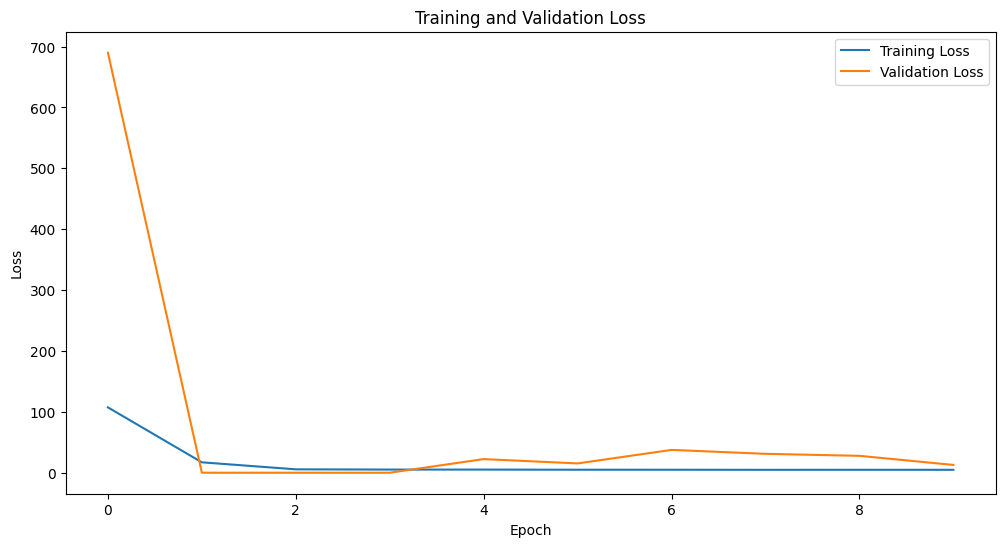

In [7]:
plot_loss_and_val_loss(train_feedback)

7. Пiдготувати декiлька прикладiв знаходження об’єктiв на зображеннях з датасету чи на вiдео.

2024-12-13 23:32:53.171713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:32:53.992036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-13 23:32:54.191984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 1s 560ms/step


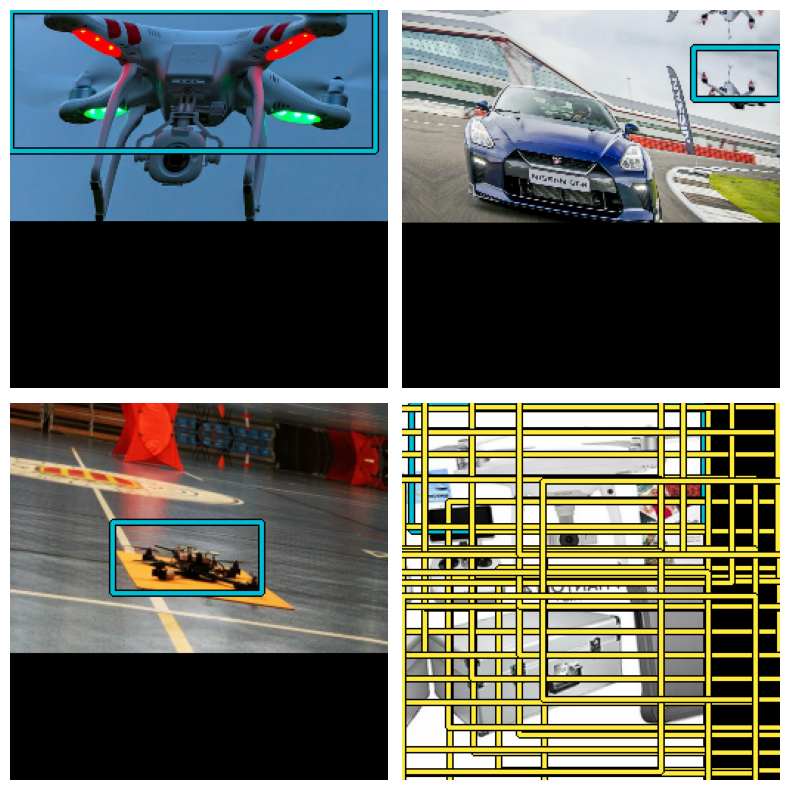

In [8]:
visualize_detections(yolo, dataset=train_ds, bounding_box_format="xyxy", class_mapping=class_mapping)